<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/object_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load and visualize the data

In [1]:
# install albumentations and timm (these two libraries are not installed in colab)
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-jon2aizz
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-jon2aizz
     |████████████████████████████████| 47.8 MB 1.8 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=53dba7bc5e5816b5d96292e460502f5aadf8b5bf843b8b8570545a6f97a179f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-zc3lqzoy/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 431 kB 8.1 MB/s 


In [2]:
# download the dataset
!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 13.73 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [4]:
# import required libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
import sys
sys.path.append("/content/object-localization-dataset")

In [7]:
data_dir = "/content/object-localization-dataset/" 
df = pd.read_csv(data_dir + "train.csv")
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


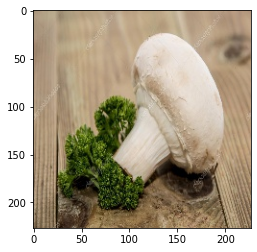

In [8]:
# visualize an image
image = df.iloc[5]
img = cv2.imread(data_dir + image.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

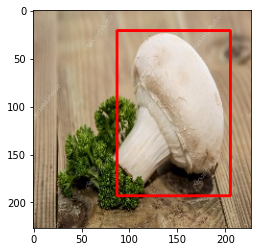

In [9]:
# visualize an image with bounding box
pt1 = (image.xmin, image.ymin)
pt2 = (image.xmax, image.ymax)
b_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0),2)
plt.imshow(b_box_img)

In [10]:
# split the dataset into train and validation datasets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
# augment some data using albumentations package
import albumentations as A

data_aug_train = A.Compose([A.Resize(140, 140),
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                            A.Rotate()], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

data_aug_val = A.Compose([A.Resize(140, 140),], 
                          bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [38]:
# create custom dataset
class ObjLocData(torch.utils.data.Dataset):
  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
      image = self.df.iloc[idx]
      xmin = image.xmin
      ymin = image.ymin
      xmax = image.xmax
      ymax = image.ymax

      bbox = [[xmin, ymin, xmax, ymax]]

      image_path = data_dir + image.img_path
      img = cv2.imread(image_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      if self.augmentations:
        data = self.augmentations(image=img, bboxes=bbox, class_labels=[None])
        img = data['image']
        bbox = data['bboxes'][0]

      img = torch.from_numpy(img).permute(2,0,1)/255.0 # (h,w,c) -> (c,h,w)
      bbox = torch.Tensor(bbox)

      return img, bbox

In [39]:
train_data = ObjLocData(train_df, data_aug_train)
val_data = ObjLocData(val_df, data_aug_val)

print('Num training images: ', len(train_data))
print('Num test images: ', len(val_data))

Num training images:  148
Num test images:  38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


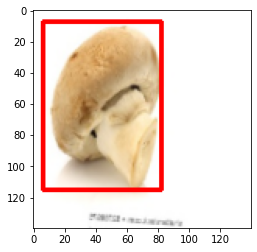

In [40]:
img, bbox = train_data[100]
xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1,2,0).numpy(), pt1, pt2, (255,0,0),2)
plt.imshow(bnd_img)

In [41]:
# prepare data loaders (combine dataset and sampler)
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

print("Number of batches in train loader: ", len(train_loader))
print("Number of batches in valid loader: ", len(val_loader))

Number of batches in train loader:  10
Number of batches in valid loader:  3


In [42]:
for imges, bboxes in train_loader:
  break
print("Shape of a batch images: ", imges.shape)
print("Shape of a batch bboxes: ", bboxes.shape)

Shape of a batch images:  torch.Size([16, 3, 140, 140])
Shape of a batch bboxes:  torch.Size([16, 4])


## Define a neural network

In [43]:
from torch import nn
import timm

class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4) # (num_class=4 bacause we want outputs xmin, ymin, xmax, ymax)

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)
    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss
    return bboxes

In [44]:
MODEL_NAME = "vgg16"
device = 'cuda'

model = ObjLocModel()
model.to(device)

ObjLocModel(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

In [26]:
random_img = torch.rand(1,3,140,140).cuda()
model(random_img).shape

torch.Size([1, 4])

## Train the model

In [56]:
import torch.optim as optim

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [59]:
# number of epochs to train the model
n_epochs = 40

val_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    val_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        images, gt_bboxes = data
        images, gt_bboxes = images.to(device), gt_bboxes.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        bboxes, loss = model(images, gt_bboxes)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()

    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
      for data in tqdm(val_loader):
          # move tensors to GPU if CUDA is available
          images, gt_bboxes = data
          images, gt_bboxes = images.to(device), gt_bboxes.to(device)
          # forward pass: compute predicted outputs by passing inputs to the model
          bboxes, loss = model(images, gt_bboxes)
          # update average validation loss 
          val_loss += loss.item()

    # calculate average losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, val_loss))
    
    # save model if validation loss has decreased
    if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        val_loss_min,
        val_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        val_loss_min = val_loss

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 238.394412 	Validation Loss: 298.369649
Validation loss decreased (inf --> 298.369649).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 259.360127 	Validation Loss: 270.220403
Validation loss decreased (298.369649 --> 270.220403).  Saving model ...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 238.260367 	Validation Loss: 307.926392


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 222.735603 	Validation Loss: 275.637451


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 213.360686 	Validation Loss: 292.762736


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 257.806416 	Validation Loss: 288.032715


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 229.417761 	Validation Loss: 281.526082


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 245.719878 	Validation Loss: 313.622742


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 261.614493 	Validation Loss: 282.275269


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 234.229408 	Validation Loss: 308.100418


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 281.911528 	Validation Loss: 444.443451


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 340.885312 	Validation Loss: 493.960429


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 342.737389 	Validation Loss: 271.977173


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 246.824159 	Validation Loss: 367.936015


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 289.325185 	Validation Loss: 364.495290


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 304.250490 	Validation Loss: 387.957977


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 253.852699 	Validation Loss: 384.727915


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 274.343692 	Validation Loss: 293.020920


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 252.453978 	Validation Loss: 315.244904


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 256.825035 	Validation Loss: 352.815145


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 270.808130 	Validation Loss: 273.016820


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 223.860112 	Validation Loss: 295.505910


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 249.734283 	Validation Loss: 278.975474


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 263.602455 	Validation Loss: 358.653310


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 245.988402 	Validation Loss: 363.987335


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 253.550693 	Validation Loss: 275.100286


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 254.450447 	Validation Loss: 364.200490


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 239.516087 	Validation Loss: 274.372864


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 228.930394 	Validation Loss: 300.550954


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 251.190254 	Validation Loss: 349.415161


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 243.549995 	Validation Loss: 276.675232


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 230.710425 	Validation Loss: 282.239502


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 234.379990 	Validation Loss: 322.981542


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 229.768552 	Validation Loss: 308.560872


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 233.097551 	Validation Loss: 344.032883


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 226.076190 	Validation Loss: 320.098160


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 253.304924 	Validation Loss: 318.549942


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 269.859268 	Validation Loss: 289.739065


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 250.773796 	Validation Loss: 280.167486


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 241.235652 	Validation Loss: 353.073090


## Test the Trained Network

In [60]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('model_augmented.pt'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


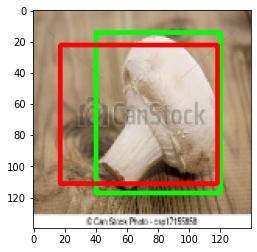

In [61]:
import utils

model.eval()

with torch.no_grad():
  image, gt_bbox = val_data[23]
  image = image.unsqueeze(0).to(device)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)

In [ ]:
mo